In [1]:
import numpy as np

import os

from statsmodels.stats.api import DescrStatsW
from scipy.stats import ttest_rel, sem

import matplotlib.pyplot as plt
import seaborn as sns
import tikzplotlib

In [2]:
def labels_to_counts(labels, time_axis=0):
    onehot = np.zeros((labels.size, n_classes), dtype=int)
    onehot[np.arange(labels.size), labels] = 1
    
    return onehot.cumsum(axis=time_axis)


def log_utility(counts):
    return np.log(counts[:, 1:] + 1).sum(axis=1)


def linear_utility(counts):
    return counts[:, 1:].sum(axis=1)


data = 'morgan'

# group_size = 1
# num_exps = 120
# num_repeats_per_exp = 5

group_size = 4
num_exps = 20
num_repeats_per_exp = 1

policies = [
    # 'ens jensen greedy_500',
    # 'classical ens_500',
    # 'greedy',
    # 'round robin greedy',
    # 'round robin ens_500',
    # 'round robin ucb_3.0',
    # 'malkomes_0.25',
    # 'malkomes_0.5',
    # 'malkomes_0.75',
    # 'he_cabornell',
    "van_0.75_3.00",
    "van_0.75_10.00",
]
names = [
    # 'D-ENS',
    # 'ENS',
    # 'One-step',
    # 'RR-greedy',
    # 'RR-ENS',
    # 'RR-UCB',
    # '0.25',
    # '0.5',
    # '0.75',
    # 'HC',
    "Van_3",
    "Van_10",
]

# policies = [
#     'round robin ucb_0.1',
#     'round robin ucb_0.3',
#     'round robin ucb_1.0',
#     'round robin ucb_3.0',
#     'round robin ucb_10.0',
# ]
# names = policies

assert len(policies) == len(names)
if group_size == 1 and 'round robin greedy' in policies:
    policies.remove('round robin greedy')
    
utility_function = log_utility

n_classes = group_size + 1
init_size = 1
budget = 500

# basepath = os.path.join('../../data/results', data)
# basepath = os.path.join('../../data/results/results_ucb_main', data)
# basepath = os.path.join('../../data/results/results_malkomes', data)
# basepath = os.path.join('../../data/results/results_he_carbonell', data)
basepath = os.path.join('../../data/results/results_van', data)


utilities = np.ones(
    (len(policies), num_exps, num_repeats_per_exp, budget + init_size)
) * -1
class_counts = -1 * np.ones(
    (len(policies), num_exps, init_size + budget, n_classes), dtype=int
)

for p_ind, policy in enumerate(policies):
    for exp_ind in range(num_exps):
        path = os.path.join(basepath, f'{data}{exp_ind + 1}', str(group_size), policy)
        for i in range(num_repeats_per_exp):
            try:
                labels = np.loadtxt(
                    os.path.join(path, f'{policy}__labels__{i + 1}.csv'), 
                    dtype=int
                ).flatten() - 1

                utilities[p_ind, exp_ind, i, :] = utility_function(labels_to_counts(labels))
                class_counts[p_ind, exp_ind, :, :] = labels_to_counts(labels)
            except OSError:
                print(os.path.join(path, f'{policy}__labels__{i + 1}.csv'))
                print(policy, exp_ind + 1, i + 1)
        
assert np.all(utilities != -1)

../../data/results/results_van/morgan/morgan1/4/van_0.75_10.00/van_0.75_10.00__labels__1.csv
van_0.75_10.00 1 1
../../data/results/results_van/morgan/morgan3/4/van_0.75_10.00/van_0.75_10.00__labels__1.csv
van_0.75_10.00 3 1
../../data/results/results_van/morgan/morgan4/4/van_0.75_10.00/van_0.75_10.00__labels__1.csv
van_0.75_10.00 4 1
../../data/results/results_van/morgan/morgan5/4/van_0.75_10.00/van_0.75_10.00__labels__1.csv
van_0.75_10.00 5 1
../../data/results/results_van/morgan/morgan10/4/van_0.75_10.00/van_0.75_10.00__labels__1.csv
van_0.75_10.00 10 1
../../data/results/results_van/morgan/morgan11/4/van_0.75_10.00/van_0.75_10.00__labels__1.csv
van_0.75_10.00 11 1
../../data/results/results_van/morgan/morgan13/4/van_0.75_10.00/van_0.75_10.00__labels__1.csv
van_0.75_10.00 13 1
../../data/results/results_van/morgan/morgan15/4/van_0.75_10.00/van_0.75_10.00__labels__1.csv
van_0.75_10.00 15 1


AssertionError: 

In [ ]:
class_counts.shape

In [3]:
for p_ind, policy in enumerate(policies):
    print(f'{policy}: {(class_counts[p_ind, :, -1, :] > 0).sum(axis=1).mean(axis=0)}')

van_0.75_3.00: 5.95
van_0.75_10.00: 5.45


In [5]:
for p1 in range(len(policies) - 1):
    for p2 in range(p1 + 1, len(policies)):
        if (class_counts[p1, :, -1, :] > 0).sum(axis=1).mean(axis=0) < (class_counts[p2, :, -1, :] > 0).sum(axis=1).mean(axis=0):
            alternative = "less"
        else:
            alternative = "greater"
        
        print(policies[p1], "vs.", policies[p2])
        print(
            ttest_rel(
                (class_counts[p1, :, -1, :] > 0).sum(axis=1), 
                (class_counts[p2, :, -1, :] > 0).sum(axis=1),
                # alternative=alternative
            ).pvalue
        )
    print()

In [6]:
utilities.shape

(1, 20, 1, 501)

In [7]:
utilities[..., -1].mean(axis=(1, 2))

array([7.19429815])

he_cabornell: 7.19


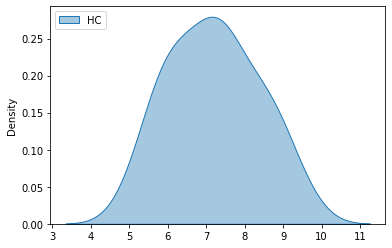

In [8]:
for p_ind, policy in enumerate(policies):
    print(f'{policy}: {utilities[p_ind, ..., -1].mean():.2f}')
    sns.kdeplot(utilities[p_ind, ..., -1].flatten(), alpha=0.4, shade=True, label=names[p_ind])
    
plt.legend(loc='upper left');

In [9]:
print(utilities.shape)
utilities

(3, 20, 1, 501)


array([[[[ 0.69314718,  0.69314718,  0.69314718, ..., 11.95452962,
          11.95452962, 11.95452962]],

        [[ 0.69314718,  0.69314718,  0.69314718, ..., 14.59358695,
          14.59358695, 14.59358695]],

        [[ 0.69314718,  0.69314718,  0.69314718, ..., 15.10441257,
          15.10441257, 15.10441257]],

        ...,

        [[ 0.69314718,  0.69314718,  0.69314718, ..., 16.25959521,
          16.25959521, 16.25959521]],

        [[ 0.69314718,  0.69314718,  0.69314718, ..., 11.36674295,
          11.36674295, 11.36674295]],

        [[ 0.69314718,  0.69314718,  0.69314718, ..., 17.58931922,
          17.58931922, 17.58931922]]],


       [[[ 0.69314718,  0.69314718,  0.69314718, ..., 14.85595121,
          14.85595121, 14.85595121]],

        [[ 0.69314718,  1.38629436,  1.38629436, ..., 19.72348566,
          19.72348566, 19.72348566]],

        [[ 0.69314718,  0.69314718,  0.69314718, ..., 20.76551948,
          20.76551948, 20.76551948]],

        ...,

        [[ 0.693

In [10]:
squeezed_utilities =  utilities.reshape(
    len(policies), 
    num_exps * num_repeats_per_exp, 
    budget + init_size
)

print(squeezed_utilities.shape)
squeezed_utilities

(3, 20, 501)


array([[[ 0.69314718,  0.69314718,  0.69314718, ..., 11.95452962,
         11.95452962, 11.95452962],
        [ 0.69314718,  0.69314718,  0.69314718, ..., 14.59358695,
         14.59358695, 14.59358695],
        [ 0.69314718,  0.69314718,  0.69314718, ..., 15.10441257,
         15.10441257, 15.10441257],
        ...,
        [ 0.69314718,  0.69314718,  0.69314718, ..., 16.25959521,
         16.25959521, 16.25959521],
        [ 0.69314718,  0.69314718,  0.69314718, ..., 11.36674295,
         11.36674295, 11.36674295],
        [ 0.69314718,  0.69314718,  0.69314718, ..., 17.58931922,
         17.58931922, 17.58931922]],

       [[ 0.69314718,  0.69314718,  0.69314718, ..., 14.85595121,
         14.85595121, 14.85595121],
        [ 0.69314718,  1.38629436,  1.38629436, ..., 19.72348566,
         19.72348566, 19.72348566],
        [ 0.69314718,  0.69314718,  0.69314718, ..., 20.76551948,
         20.76551948, 20.76551948],
        ...,
        [ 0.69314718,  1.38629436,  1.38629436, ..., 1

In [11]:
for p1 in range(len(policies) - 1):
    for p2 in range(p1 + 1, len(policies)):
        if squeezed_utilities[p1, :, -1].mean() < squeezed_utilities[p2, :, -1].mean():
            alternative = "less"
        else:
            alternative = "greater"
        
        print(policies[p1], "vs.", policies[p2])
        print(
            ttest_rel(
                squeezed_utilities[p1, :, -1], 
                squeezed_utilities[p2, :, -1],
                # alternative=alternative
            ).pvalue
        )
    print()

malkomes_0.25 vs. malkomes_0.5
2.2016806524871334e-05
malkomes_0.25 vs. malkomes_0.75
3.3420796580577816e-16

malkomes_0.5 vs. malkomes_0.75
1.5032853496470555e-14



14.854664314471869 17.004547891514587
0.54
18.28544897465845 20.92192537669586
0.66
34.64442138425574 37.65880353546891
0.75


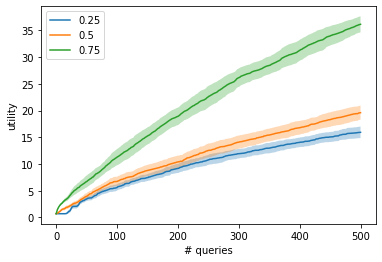

In [12]:
plt.figure()

for p_ind, policy in enumerate(policies):
    plt.plot(squeezed_utilities[p_ind].mean(axis=0), label=names[p_ind])
    lower, upper = DescrStatsW(squeezed_utilities[p_ind]).tconfint_mean()
    plt.fill_between(np.arange(init_size + budget), lower, upper, alpha=0.3)
    
    print(lower[-1], upper[-1])
    print(f'{(upper[-1] - lower[-1]) / 4:.2f}')
    
plt.xlabel("# queries")
plt.ylabel("utility")
plt.legend()

tikzplotlib.save("reward.tex")

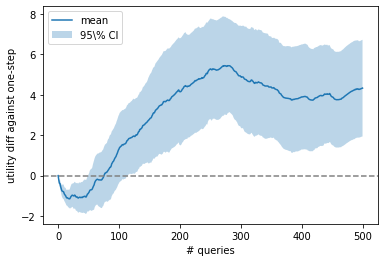

In [12]:
diff = squeezed_utilities[0] - squeezed_utilities[1]
lower, upper = DescrStatsW(diff).tconfint_mean()

plt.plot(diff.mean(axis=0), label="mean")
plt.fill_between(np.arange(init_size + budget), lower, upper, alpha=0.3, label="95\% CI")

plt.axhline(0, c="gray", linestyle="--")

plt.xlabel("# queries")
plt.ylabel("utility diff against one-step")
# plt.ylim(-5, 30)

plt.legend(loc="upper left")

# plt.show()
tikzplotlib.save("reward_diff.tex")